In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

In [2]:
from scipy.stats import median_abs_deviation as mad

In [3]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [4]:
plt.style.use('seaborn-notebook')
plt.style.use('ggplot')

In [5]:
import pymc3 as pm

# 11.1 Assumpitons of regression model

## the model

In [6]:
hibbs = pd.read_csv('../ROS-Examples/ElectionsEconomy/data/hibbs.dat', sep=' ')

In [7]:
hibbs.head()

,year,growth,vote,inc_party_candidate,other_candidate
0,1952,2.40,44.60,Stevenson,Eisenhower
1,1956,2.89,57.76,Eisenhower,Stevenson
2,1960,0.85,49.91,Nixon,Kennedy
3,1964,4.21,61.34,Johnson,Goldwater
4,1968,3.02,49.60,Humphrey,Nixon


In [8]:
with pm.Model() as model:
    pm.glm.linear.GLM.from_formula('vote~growth', hibbs)
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sd, growth, Intercept]


Sampling 3 chains for 1_000 tune and 10_000 draw iterations (3_000 + 30_000 draws total) took 9 seconds.


In [12]:
trace_df = pm.trace_to_dataframe(trace[:3000])
trace_df.mean()

Intercept    46.248847
growth        3.060345
sd            4.091421
dtype: float64

In [13]:
hibbs['year'].sort_values

<bound method Series.sort_values of 0     1952
1     1956
2     1960
3     1964
4     1968
5     1972
6     1976
7     1980
8     1984
9     1988
10    1992
11    1996
12    2000
13    2004
14    2008
15    2012
Name: year, dtype: int64>

## Assumption 1: Validity

Is the research question mapped reasonably to the data? The model is called `bread and peace`. So th eidea is that if the populance gets enough "bread" (i.e. economy doing well), they would vote in a certain way towards the incumbents. I think this makes sense. There is not really a question of sampling aside from choosing the years and the country (US). The country is a choice for the study, the years have been chosen presumably for the availablility of data and does not appear to have skipped any special term. 

## Assumption 2: Representativeness

This dataset is a case where there is no real selection of data as explained above, but the potential issue from representativeness comes from the fact that we assume the past and the future elections are sub-populations of one super-population. There are at least 2 possible issues at stake: 

1. The population composition itself has changed over the course of years, with more immigration and decline of birth rate. This would represent a gradual shift of attitudes over the years and therefore the data is not really a random selection from a super popualtion 

2. Economic growth definition: the way we define economic growth is the average growth in personal income. This does not take into consideration the inflation as well as asset value change. If inflation was higher than income growth, then effective purchase power has actually gone down; If asset valuation changes a lot either way, the wealth of individuals would be influenced by this and also that influence would be very unequal across social classes (with or without assets)


These issues could be addressed by adding new predicators that would take these factors into considerations. Increase to net worth as opposed to net income, for example, might address some of these issues. Adding purchase power parity for example might help as well. The population composition shift is hard to accommodate, but it's possible that accommodating for different income classes might address that issue as well. 

## Assumption 3: additivity and linearity

We chose to do this model as a linear model since there is only one predicator. There is no additivity which would come into play if we add more predicators. There is no a priori reason why it would not be linear, so I think this assumption is valid. 

## Assumption 4: independence of errors

I do think there is some auto-correlation within elections (because it's a time series), so this assumption is violated

## Assumption 5: Equal variance of errors

This is probably also violated given errors are not even independent

## Assumption 6: Normality of errors

We make this assumption based on our model, but I do not think there is much to change on this front

# 11.2 Descriptive and causal inference

In [14]:
trace_df.mean()

Intercept    46.248847
growth        3.060345
sd            4.091421
dtype: float64

## Descriptive:
On average, the vote share of the incumbent would be increased by 3.06% for every 1% increase in personal income

## Causual

We would say then a 1% increase in personal income would increase the incumbent's vote share by 3.06%, which, if used in prediction of elections, is hardly relevant since we must consider all other issues at stake. Also, since growth is almost almost positive, it would have predicted that every incumbent would just kept winnning elections in vote share (since they obviously won the previous one), which is not necessarily true

# 11.3 Coverage of confidence intervals

In [34]:
def simulate_y(n):
    x = np.random.uniform(0,10,n)
    y = 2+3*x+np.random.normal(0,size = n)
    return x,y

In [37]:
def repeated_regression(N, n):
    slope_list = []
    mad_sd =[]
    x,y = simulate_y(n)
    for i in range(0,N):
        with pm.Model() as model:
            pm.glm.GLM(x,y,intercept=True)
            trace = pm.sample(1000)
        trace_df = pm.trace_to_dataframe(trace[:300])
        slope_list.append(trace_df['x0'].median())
        mad_sd.append(trace_df['x0'].mad())
    return slope_list, mad_sd

In [ ]:
slope, mad_sd = repeated_regression(100, 100) #this will take a while

this took too long, we will just do once

In [41]:
slope, mad_sd = repeated_regression(1, 100) #this will take a while

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sd, x0, Intercept]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 2 seconds.


In [42]:
slope

[2.9748300392993636]

In [43]:
mad_sd

[0.032930372642943]

So yes, slope $ \pm $ 2 $ \times $mad_sd

# 11.4 Interpreting residual plots

The residual plots would be non-linear if we do not have interactions term

In [69]:
x = np.random.uniform(0,10,100)
x2 = np.random.binomial(1, 0.5,100)
y = 2+3*x+np.random.normal(0,size = 100)+x2*x*5

In [70]:
data = pd.DataFrame({'x':x, 'x2':x2, 'y':y})

In [71]:
data

,x,x2,y
0,6.022735,1,50.418891
1,7.256480,0,23.376753
2,0.564837,0,3.153016
3,3.025347,0,10.879114
4,9.960666,1,80.915877
...,...,...,...
95,3.913465,0,11.583940
96,0.322724,0,2.920160
97,6.828352,1,55.812607
98,4.085145,1,34.854781


In [72]:
with pm.Model() as model:
    pm.glm.linear.GLM.from_formula('y~x+x2', data)
    trace = pm.sample(10000)
trace_df = pm.trace_to_dataframe(trace[:3000])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sd, x2, x, Intercept]


Sampling 3 chains for 1_000 tune and 10_000 draw iterations (3_000 + 30_000 draws total) took 13 seconds.
The acceptance probability does not match the target. It is 0.8789582274690785, but should be close to 0.8. Try to increase the number of tuning steps.


In [73]:
coeff = trace_df.median()

In [74]:
coeff['x']

4.979243801322451

In [75]:
coeff

Intercept    -8.313672
x             4.979244
x2           24.945949
sd            6.272814
dtype: float64

In [76]:
y_hat = coeff['x']*x+coeff['x2']*x2+coeff['Intercept']

In [79]:
data['y_hat'] = y_hat

In [81]:
data['residual'] = y-y_hat

In [82]:
data

,x,x2,y,y_hat,residual
0,6.022735,1,50.418891,46.620944,3.797947
1,7.256480,0,23.376753,27.818113,-4.441360
2,0.564837,0,3.153016,-5.501211,8.654226
3,3.025347,0,10.879114,6.750269,4.128845
4,9.960666,1,80.915877,66.228864,14.687013
...,...,...,...,...,...
95,3.913465,0,11.583940,11.172422,0.411518
96,0.322724,0,2.920160,-6.706750,9.626910
97,6.828352,1,55.812607,50.632308,5.180299
98,4.085145,1,34.854781,36.973213,-2.118432


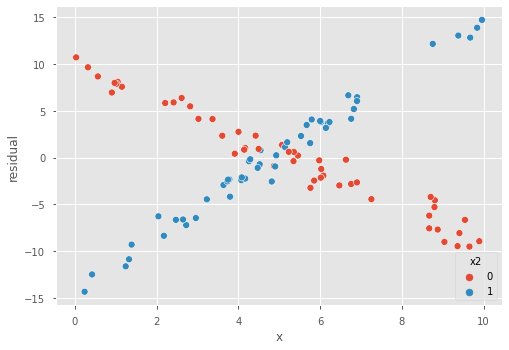

In [87]:
sns.scatterplot(data = data, x='x', y='residual',hue='x2')

For example, suppose $y = ax_1+bx_2+c+dx_1x_2$, and $\hat{y} = \hat{a}x_1+\hat{b}x_2+c$, then

$$
residual = y-\hat{y} = (a-\hat{a})x_1+(b-\hat{b})x_2+c-\hat{c}+dx_1x_2
$$

which means if we plot residual against $x_1$, then we get
$$
res \sim (a-\hat{a}+d)x_1
$$
if $x_2 = 1$, else
$$
res \sim (a-\hat{a})x_1
$$

Therefore the slope will change, in our case this is dramatic (flipped)

in terms of why the error term is correlated with the data $y$, see [this lecture notes](https://www.stat.berkeley.edu/~census/epsilon.pdf), but essentially the error term is correlated with each data point 

# 11.5 Residuals and Predictions

In [97]:
data = pd.read_csv('~/projects/ROS-Examples/Pyth/pyth.txt', sep=' ')

In [98]:
data.head()

,y,x1,x2
0,15.68,6.87,14.09
1,6.18,4.40,4.35
2,18.10,0.43,18.09
3,9.07,2.73,8.65
4,17.97,3.25,17.68


In [99]:
len(data)

60

In [100]:
train = data[:40]

In [103]:
test = data[40:]

In [105]:
with pm.Model() as model:
    pm.glm.linear.GLM.from_formula('y~x1+x2', train)
    trace = pm.sample(10000)
trace_df = pm.trace_to_dataframe(trace[:3000])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sd, x2, x1, Intercept]


Sampling 3 chains for 1_000 tune and 10_000 draw iterations (3_000 + 30_000 draws total) took 14 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8854858172271063, but should be close to 0.8. Try to increase the number of tuning steps.


In [106]:
coeff = trace_df.median()

In [107]:
coeff

Intercept    1.312393
x1           0.514158
x2           0.807044
sd           0.917930
dtype: float64

In [130]:
coeff

Intercept    1.312393
x1           0.514158
x2           0.807044
sd           0.917930
dtype: float64

Calcualting Bayes R is really hard in this context, just do residual

In [138]:
y_hat =  coeff['x1']*train['x1']+coeff['x2']*train['x2']+coeff['Intercept'] 

In [139]:
res = y_hat- train['y']

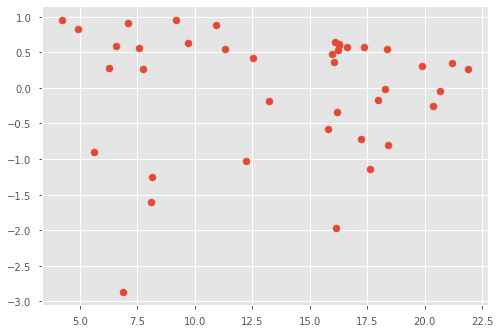

In [140]:
plt.scatter(x = y_hat , y = res)

does not look all that well I would say, the scatter is not uniform across y_hat values